In [1]:
%load_ext autoreload
%load_ext tensorboard
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import os
import random
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import joblib
import torch
import pandas as pd
import copy

# Set the font to a nicer font
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "serif"

# Load the Data

In [87]:
result_dir = "/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/"
with open('/homes/me466/cem/experiments/configs/mixcem_awa2_incomplete.yaml', "r") as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)

id_dataset_config =  {
    "dataset": "awa2",
    "num_workers": 8,
    "batch_size": 512,

    # DATASET VARIABLES
    "root_dir": "/anfs/bigdisc/me466/AwA2/Animals_with_Attributes2",
    "sampling_percent": 0.1,
    "sampling_groups": False,
    "test_subsampling": 1,
    "weight_loss": False,
}

In [96]:
import cem.utils.data as data_utils
import cem.data.awa2_loader as awa2_data_module
from cem.data.utils import transform_from_config

# test_transform_config = dict(
#     name='salt_and_pepper',
#     s_vs_p=0.5,
#     amount=0.1,
# )

test_transform_config = dict(
    name='random_noise',
    low_noise_level=1,
    noise_level=0.5,
)

test_transform_fn = transform_from_config(test_transform_config)
_, _, id_test_dl, _, (n_concepts, n_tasks, concept_map) = \
    awa2_data_module.generate_data(
        config=id_dataset_config,
        seed=42,
        output_dataset_vars=True,
        root_dir=id_dataset_config.get('root_dir', None),
    )
id_x_test, id_y_test, id_c_test = data_utils.daloader_to_memory(id_test_dl)


_, _, ood_test_dl, imbalance, (n_concepts, n_tasks, concept_map) = \
    awa2_data_module.generate_data(
        config=id_dataset_config,
        seed=42,
        output_dataset_vars=True,
        root_dir=id_dataset_config.get('root_dir', None),
        test_sample_transform=test_transform_fn,
    )
ood_x_test, ood_y_test, ood_c_test = data_utils.daloader_to_memory(ood_test_dl)

Global seed set to 42


		Selected concepts: [ 0  4 10 12 18 22 68 78 82]
		Updated concept group map (with 6 groups):
			color -> [0, 1]
			fur_pattern -> [2, 3]
			limb_shape -> [4, 5]
			biome -> [6]
			fierceness -> [7]
			social_mode -> [8]
TRAIN AWA2 dataset has: 22393 samples
VAL AWA2 dataset has: 7464 samples
TEST AWA2 dataset has: 7465 samples


# Load the Models to be Used

In [ ]:
import experiments.experiment_utils as experiment_utils
import joblib
split = 0
selected_models = joblib.load(
    os.path.join(result_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'),
)

In [ ]:
models_to_include = [
    ("Hybrid CBM", "Hybrid-CBM (Baseline)"),
    ("CEM", "CEM (Baseline)"),
    ("IntCEM", "IntCEM (Baseline)"),
    ("MixCEM", "Entropy CMCMixCEM (Baseline)"),
]

# Generate the Bottlenecks

In [ ]:
from cem.models.construction import load_trained_model
import pytorch_lightning as pl

id_y_preds = []
id_c_preds = []
id_bottlenecks = []

id_int_y_preds = []
id_int_c_preds = []
id_int_bottlenecks = []

ood_y_preds = []
ood_c_preds = []
ood_bottlenecks = []
ood_int_y_preds = []
ood_int_c_preds = []
ood_int_bottlenecks = []

for real_model_name, used_model_name in models_to_include:
    root = selected_models[used_model_name]
    model_path = os.path.join(
        result_dir,
        root + f"_fold_{split + 1}.pt",
    )
    model_config = joblib.load(
        os.path.join(result_dir, root + "_experiment_config.joblib"),
    )

    task_class_weights = None
    model = load_trained_model(
        config=model_config,
        n_tasks=n_tasks,
        result_dir=result_dir,
        n_concepts=n_concepts,
        split=split,
        imbalance=imbalance,
        task_class_weights=task_class_weights,
        train_dl=None,
        logger=False,
        output_latent=False,
        output_interventions=False,
        enable_checkpointing=False,
    )
    trainer = pl.Trainer(
        gpus=1,
        logger=False,
    )

    print("Unintervened ID Bottlenecks for", real_model_name)
    id_test_batch_results = trainer.predict(
        model,
        id_test_dl,
    )

    id_c_preds.append(np.concatenate(
        list(map(lambda x: x[0].detach().cpu().numpy(), id_test_batch_results)),
        axis=0,
    ))
    id_bottlenecks.append(np.concatenate(
        list(map(lambda x: x[1].detach().cpu().numpy(), id_test_batch_results)),
        axis=0,
    ))
    id_y_preds.append(np.concatenate(
        list(map(lambda x: x[2].detach().cpu().numpy(), id_test_batch_results)),
        axis=0,
    ))

    print("Unintervened OOD Bottlenecks for", real_model_name)
    ood_test_batch_results = trainer.predict(
        model,
        ood_test_dl,
    )
    ood_c_preds.append(np.concatenate(
        list(map(lambda x: x[0].detach().cpu().numpy(), ood_test_batch_results)),
        axis=0,
    ))
    ood_bottlenecks.append(np.concatenate(
        list(map(lambda x: x[1].detach().cpu().numpy(), ood_test_batch_results)),
        axis=0,
    ))
    ood_y_preds.append(np.concatenate(
        list(map(lambda x: x[2].detach().cpu().numpy(), ood_test_batch_results)),
        axis=0,
    ))

    model.force_all_interventions = True
    print("Intervened ID Bottlenecks for", real_model_name)
    id_int_test_batch_results = trainer.predict(
        model,
        id_test_dl,
    )

    id_int_c_preds.append(np.concatenate(
        list(map(lambda x: x[0].detach().cpu().numpy(), id_int_test_batch_results)),
        axis=0,
    ))
    id_int_bottlenecks.append(np.concatenate(
        list(map(lambda x: x[1].detach().cpu().numpy(), id_int_test_batch_results)),
        axis=0,
    ))
    id_int_y_preds.append(np.concatenate(
        list(map(lambda x: x[2].detach().cpu().numpy(), id_int_test_batch_results)),
        axis=0,
    ))

    print("Intervened OOD Bottlenecks for", real_model_name)
    ood_int_test_batch_results = trainer.predict(
        model,
        ood_test_dl,
    )
    ood_int_c_preds.append(np.concatenate(
        list(map(lambda x: x[0].detach().cpu().numpy(), ood_int_test_batch_results)),
        axis=0,
    ))
    ood_int_bottlenecks.append(np.concatenate(
        list(map(lambda x: x[1].detach().cpu().numpy(), ood_int_test_batch_results)),
        axis=0,
    ))
    ood_int_y_preds.append(np.concatenate(
        list(map(lambda x: x[2].detach().cpu().numpy(), ood_int_test_batch_results)),
        axis=0,
    ))

/home/me466/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened ID Bottlenecks for Hybrid CBM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened OOD Bottlenecks for Hybrid CBM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened ID Bottlenecks for Hybrid CBM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened OOD Bottlenecks for Hybrid CBM


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened ID Bottlenecks for CEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened OOD Bottlenecks for CEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened ID Bottlenecks for CEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened OOD Bottlenecks for CEM


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened ID Bottlenecks for IntCEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened OOD Bottlenecks for IntCEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened ID Bottlenecks for IntCEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened OOD Bottlenecks for IntCEM


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened ID Bottlenecks for MixCEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened OOD Bottlenecks for MixCEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened ID Bottlenecks for MixCEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened OOD Bottlenecks for MixCEM


Predicting: 0it [00:00, ?it/s]

# Visualize the Bottlenecks

In [ ]:
from sklearn.manifold import TSNE
import random
random.seed(42)
np.random.seed(42)

freq = 10
perplexity = 50
n_iter = 1000
tsne_id_bottlenecks = []
tsne_ood_bottlenecks = []
tsne_combined_bottlenecks = []
tsne_no_int_bottlenecks = []
tsne_int_bottlenecks = []
used_subset = list(range(0, id_bottlenecks[0].shape[0], freq))
n_samples = len(used_subset)
for model_idx, (real_model_name, used_model_name) in enumerate(models_to_include):
    print("Projecting bottlenecks for", real_model_name)
    test_tsne = TSNE(
        n_components=2,
        verbose=1,
        perplexity=perplexity,
        n_iter=n_iter,
        init='pca',
        learning_rate='auto',
    )
    merged_bottleneck_data =  np.concatenate(
        [
            np.reshape(id_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
            np.reshape(ood_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
        ],
        axis=0,
    )
    tsne_no_int_bottlenecks.append(
        test_tsne.fit_transform(merged_bottleneck_data)
    )
    
    merged_bottleneck_data =  np.concatenate(
        [
            np.reshape(id_int_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
            np.reshape(ood_int_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
        ],
        axis=0,
    )
    tsne_int_bottlenecks.append(
        test_tsne.fit_transform(merged_bottleneck_data)
    )
    
    
    # merged_bottleneck_data =  np.concatenate(
    #     [
    #         np.reshape(id_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
    #         np.reshape(id_int_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
    #     ],
    #     axis=0,
    # )
    # tsne_id_bottlenecks.append(
    #     test_tsne.fit_transform(merged_bottleneck_data)
    # )

    # merged_bottleneck_data =  np.concatenate(
    #     [
    #         np.reshape(ood_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
    #         np.reshape(ood_int_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
    #     ],
    #     axis=0,
    # )
    # tsne_ood_bottlenecks.append(
    #     test_tsne.fit_transform(merged_bottleneck_data)
    # )

    # merged_bottleneck_data =  np.concatenate(
    #     [
    #         np.reshape(id_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
    #         np.reshape(ood_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
    #         np.reshape(id_int_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
    #         np.reshape(ood_int_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
    #     ],
    #     axis=0,
    # )
    # tsne_combined_bottlenecks.append(
    #     test_tsne.fit_transform(merged_bottleneck_data)
    # )

Projecting bottlenecks for Hybrid CBM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1494 samples in 0.000s...
[t-SNE] Computed neighbors for 1494 samples in 0.110s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1494
[t-SNE] Computed conditional probabilities for sample 1494 / 1494
[t-SNE] Mean sigma: 1.070874


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.752113
[t-SNE] KL divergence after 1000 iterations: 0.810361
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1494 samples in 0.000s...
[t-SNE] Computed neighbors for 1494 samples in 0.075s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1494
[t-SNE] Computed conditional probabilities for sample 1494 / 1494
[t-SNE] Mean sigma: 1.073543


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


KeyboardInterrupt: 

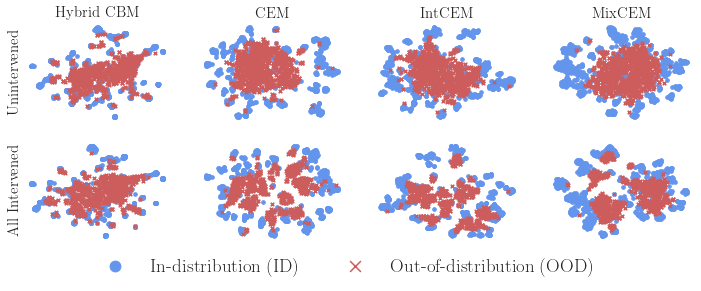

In [ ]:
figsize = (3 * len(models_to_include), 4)
fig, axs = plt.subplots(
    2,
    len(models_to_include),
    figsize=figsize,
)

id_color = 'cornflowerblue'
ood_color = 'indianred'

for model_idx, (real_model_name, used_model_name) in enumerate(models_to_include):
    ax = axs[0, model_idx]
    ax.scatter(
        tsne_no_int_bottlenecks[model_idx][:n_samples, 0],
        tsne_no_int_bottlenecks[model_idx][:n_samples, 1],
        color=id_color,
        label=f"In-distribution (ID)",
        marker='o',
        alpha=1,
        s=13,
    )
    ax.scatter(
        tsne_no_int_bottlenecks[model_idx][n_samples:, 0],
        tsne_no_int_bottlenecks[model_idx][n_samples:, 1],
        color=ood_color,
        label=f"Out-of-distribution (OOD)",
        marker='x',
        alpha=1,
        s=13,
    )

    ax.set_title(real_model_name, fontsize=15)
    if model_idx == 0:
        ax.set_ylabel("Unintervened", fontsize=15)
    ax.grid(False)
    # Remove the axis line, ticks, and tick labels for the x-axis
    ax.xaxis.set_ticks([])  # Remove tick marks
    ax.xaxis.set_ticklabels([])  # Remove tick labels
    ax.spines['bottom'].set_visible(False)  # Hide the axis line
    ax.spines['top'].set_visible(False)  # Hide the axis line

    # Remove the axis line, ticks, and tick labels for the y-axis (optional)
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)


    ax = axs[1, model_idx]
    ax.scatter(
        tsne_int_bottlenecks[model_idx][:n_samples, 0],
        tsne_int_bottlenecks[model_idx][:n_samples, 1],
        color=id_color,
        label=f"In-distribution (ID)",
        marker='o',
        alpha=1,
        s=13,
    )
    ax.scatter(
        tsne_int_bottlenecks[model_idx][n_samples:, 0],
        tsne_int_bottlenecks[model_idx][n_samples:, 1],
        color=ood_color,
        label=f"Out-of-distribution (OOD)",
        marker='x',
        alpha=1,
        s=13,
    )

    if model_idx == 0:
        ax.set_ylabel("All Intervened", fontsize=15)
    ax.grid(False)
    # Remove the axis line, ticks, and tick labels for the x-axis
    ax.xaxis.set_ticks([])  # Remove tick marks
    ax.xaxis.set_ticklabels([])  # Remove tick labels
    ax.spines['bottom'].set_visible(False)  # Hide the axis line
    ax.spines['top'].set_visible(False)  # Hide the axis line

    # Remove the axis line, ticks, and tick labels for the y-axis (optional)
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=19,
    loc='upper center',
    bbox_to_anchor=(-1.4,0),
    ncol=2,
    markerscale=3.,
)
plt.savefig(f"figures/bottleneck_intervention_viz.pdf", bbox_inches='tight')
plt.savefig(f"figures/bottleneck_intervention_viz.png", bbox_inches='tight')
plt.show()